In [31]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))


%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


from experiments.mrmc_experiment import run_mrmc_experiment
from confidence_checks import toy_data, identity_adapter, toy_model, plotting_functions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set up the data, adapter, and model

### Get the synthetic data

The synthetic dataset has:
* 1 negatively-classified POI at (-1, 0)
* 1 positively-classified 4-point cluster at (0, 2)
* 1 positively-classified 4-point cluster at (1, 2)

Text(0.5, 1.0, 'Synthetic Dataset')

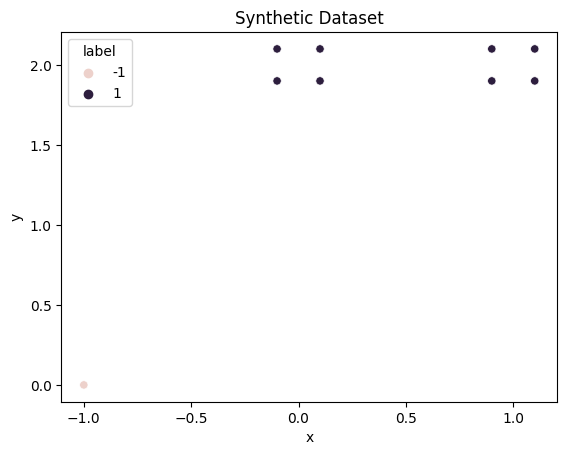

In [32]:
DATASET, DATASET_INFO = toy_data.get_data()
POI = DATASET.drop('label', axis=1).iloc[-1]

sns.scatterplot(x='x', y='y', hue="label", data=DATASET)
plt.title("Synthetic Dataset")

### Create a passthrough adapter
For ease of debugging, the adapter doesn't transform the data.

In [33]:
ADAPTER = identity_adapter.IdentityAdapter(
    label_column=DATASET_INFO.label_column,
    positive_label=DATASET_INFO.positive_label
).fit(DATASET)

### Create a simple model

There is a low- to high-confidence gradient from (-1, 0) to (1, 2)

<AxesSubplot: title={'center': 'Model Confidence Contours'}, xlabel='x', ylabel='y'>

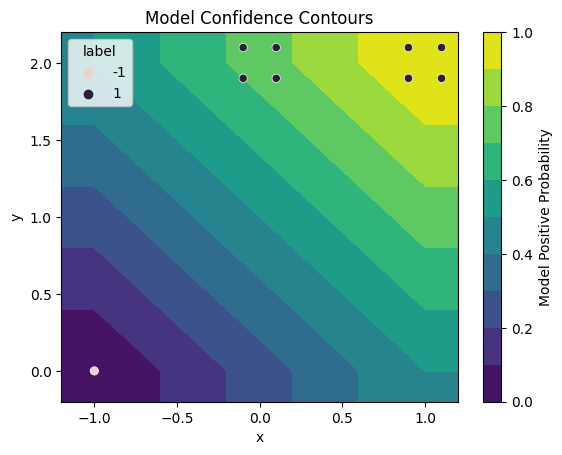

In [34]:
MODEL = toy_model.ToyModel(ADAPTER)


plotting_functions.plot_model_confidence(MODEL)
plt.title('Model Confidence Contours')
sns.scatterplot(x='x', y='y', hue='label', data=DATASET)

# Test executing batched run configs

### Do dependency injection to use the synthetic dataset, model, and adapter

In [41]:
def get_toy_data(dataset_name):
    if dataset_name == 'toy_data':
        return DATASET, DATASET_INFO
    else:
        raise RuntimeError("Only toy dataset is supported while debugging.")
run_mrmc_experiment._get_dataset = get_toy_data

def get_adapter(dataset, dataset_info, random_seed, noise_ratio, rescale_ratio):
    return identity_adapter.IdentityAdapter(
        perturb_ratio=noise_ratio,
        rescale_ratio=rescale_ratio,
        label_column=dataset_info.label_column,
        positive_label=dataset_info.positive_label,
        random_seed=random_seed
    ).fit(dataset)
run_mrmc_experiment._get_recourse_adapter = get_adapter

def get_toy_model(model_type, dataset_name):
    if model_type == 'toy_model':
        return MODEL
    else:
        raise RuntimeError("Only toy model is supported while debugging.")
run_mrmc_experiment._get_model = get_toy_model

### Test dry run

In [42]:
batch_config = {
    "experiment_name": "test_batch",
    "run_configs": [
        {
            'mock_config': 'mock_value'
        },
        {
            'mock_config': 'mock_value'
        }
    ]
}

run_mrmc_experiment.main(
    config=batch_config,
    is_experiment=False,
    verbose=True,
    dry_run=True
)

Got configs for 2 runs.
Terminate without executing runs because --dry_run is set.


### Test two runs with same seeds and arguments

In [43]:
def show_results(results_path, label_column=None):
    print("\nResults saved as:")
    print(os.listdir(results_path))

    mrmc_paths_df = pd.read_csv(os.path.join(results_path, 'mrmc_paths_df.csv'))

    plotting_functions.plot_model_confidence(MODEL, xlim=(-1.1, 1.1), ylim=(0,2.2))
    sns.scatterplot(x='x', y='y', data=DATASET, label="Dataset")

    experiment_config_df = None
    if label_column:
        experiment_config_df = pd.read_csv(
            os.path.join(results_path, 'experiment_config_df.csv'))

    plotting_functions.plot_paths_results(
        mrmc_paths_df, alpha=0.8, label_column=label_column,
        experiment_config_df=experiment_config_df)
    plt.legend()

Got configs for 2 runs.
Start executing 2 mrmc runs.
Finished run 1/2
Finished run 2/2
Saved results to /home/jakeval/umass/research/MRMC/experiment_results/mrmc_results/test_batch

Results saved as:
['mrmc_paths_df.csv', 'experiment_config_df.csv', 'config.json', 'cluster_df.csv']


Text(0.5, 1.0, 'Two runs with identical seeds are identical')

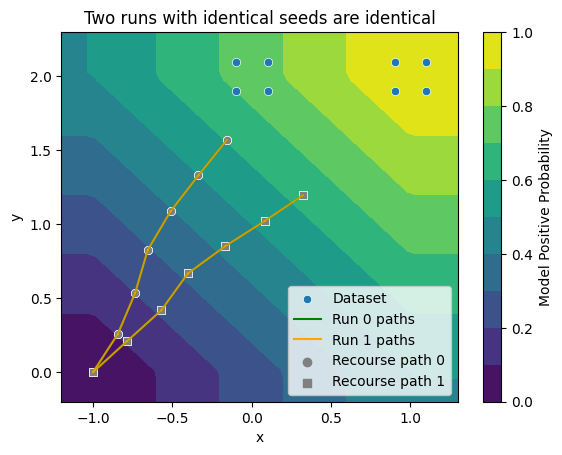

In [45]:
batch_config = {
    "experiment_name": "test_batch",
    "run_configs": [
        {
            "dataset_name": "toy_data",
            "model_type": "toy_model",
            "step_size": 0.3,
            "confidence_cutoff": 0.6,
            "noise_ratio": 0.2,
            "rescale_ratio": None,
            "volcano_degree": 2,
            "volcano_cutoff": 0.2,
            "num_clusters": 2,
            "max_iterations": 10,
            "cluster_seed": 0,
            "batch_id": 0,
            "run_id": 0,
            "run_seed": 0
        },
        {
            "dataset_name": "toy_data",
            "model_type": "toy_model",
            "step_size": 0.3,
            "confidence_cutoff": 0.6,
            "noise_ratio": 0.2,
            "rescale_ratio": None,
            "volcano_degree": 2,
            "volcano_cutoff": 0.2,
            "num_clusters": 2,
            "max_iterations": 10,
            "cluster_seed": 0,
            "batch_id": 1,
            "run_id": 1,
            "run_seed": 0
        }
    ]
}

run_mrmc_experiment.main(
    config=batch_config,
    is_experiment=False,
    verbose=True,
)

show_results('../experiment_results/mrmc_results/test_batch')
plt.title("Two runs with identical seeds are identical")

### Test two runs with identical arguments but different seeds

They should be similar but slightly different

Got configs for 2 runs.
Start executing 2 mrmc runs.
Finished run 1/2
Finished run 2/2
Saved results to /home/jakeval/umass/research/MRMC/experiment_results/mrmc_results/test_batch

Results saved as:
['mrmc_paths_df.csv', 'experiment_config_df.csv', 'config.json', 'cluster_df.csv']


Text(0.5, 1.0, 'Different seeds for noise_ratio=0.1')

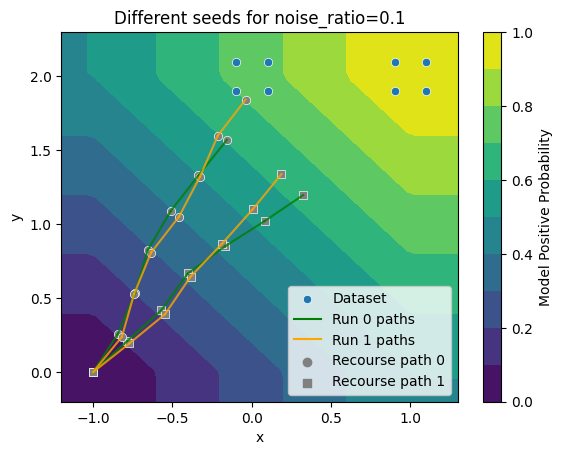

In [46]:
batch_config = {
    "experiment_name": "test_batch",
    "run_configs": [
        {
            "dataset_name": "toy_data",
            "model_type": "toy_model",
            "step_size": 0.3,
            "confidence_cutoff": 0.6,
            "noise_ratio": 0.2,
            "rescale_ratio": None,
            "volcano_degree": 2,
            "volcano_cutoff": 0.2,
            "num_clusters": 2,
            "max_iterations": 10,
            "cluster_seed": 0,
            "batch_id": 0,
            "run_id": 0,
            "run_seed": 0
        },
        {
            "dataset_name": "toy_data",
            "model_type": "toy_model",
            "step_size": 0.3,
            "confidence_cutoff": 0.6,
            "noise_ratio": 0.2,
            "rescale_ratio": None,
            "volcano_degree": 2,
            "volcano_cutoff": 0.2,
            "num_clusters": 2,
            "max_iterations": 10,
            "cluster_seed": 0,
            "batch_id": 1,
            "run_id": 1,
            "run_seed": 1
        }
    ]
}

run_mrmc_experiment.main(
    config=batch_config,
    is_experiment=False,
    verbose=True,
)

show_results('../experiment_results/mrmc_results/test_batch')
plt.title("Different seeds for noise_ratio=0.1")

# Test executing experiment configs

### Test dry run

In [47]:
experiment_config = {
    "experiment_name": "test_experiment",
    "num_runs": 2,
    "random_seed": 0,
    "parameter_ranges": {
        "step_size": [0.5],
        "confidence_cutoff": [0.6],
        "noise_ratio": [None],
        "rescale_ratio": [None],
        "volcano_degree": [2],
        "volcano_cutoff": [0.5],
        "num_clusters": [3],
        "dataset_name": ["toy_data"],
        "model_type": ["toy_model"],
        "max_iterations": [10],
        "cluster_seeds": [0]
    }
}

run_mrmc_experiment.main(
    config=experiment_config,
    is_experiment=True,
    verbose=True,
    dry_run=True,
)

Got configs for 2 runs.
Terminate without executing runs because --dry_run is set.


### Test multiple runs while varying noise_ratio

There should be 4 runs total, making 8 paths.

(2 paths per run, 2 runs per batch, 2 batches)

Got configs for 4 runs.
Start executing 4 mrmc runs.
Finished run 1/4
Finished run 2/4
Finished run 3/4
Finished run 4/4
Saved results to /home/jakeval/umass/research/MRMC/experiment_results/mrmc_results/test_experiment

Results saved as:
['mrmc_paths_df.csv', 'experiment_config_df.csv', 'config.json', 'cluster_df.csv']


Text(0.5, 1.0, 'Paths as noise_ratio changes')

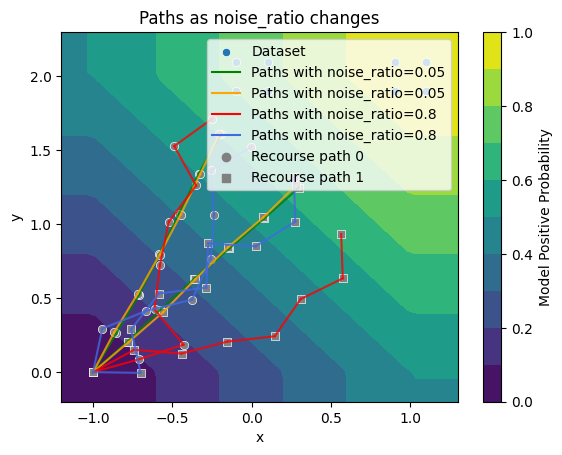

In [48]:
experiment_config = {
    "experiment_name": "test_experiment",
    "num_runs": 2,
    "random_seed": 0,
    "parameter_ranges": {
        "step_size": [0.3],
        "confidence_cutoff": [0.6],
        "noise_ratio": [0.05, 0.8],
        "rescale_ratio": [None],
        "volcano_degree": [2],
        "volcano_cutoff": [0.5],
        "num_clusters": [2],
        "dataset_name": ["toy_data"],
        "model_type": ["toy_model"],
        "max_iterations": [10],
        "cluster_seed": [0]
    }
}

run_mrmc_experiment.main(
    config=experiment_config,
    is_experiment=True,
    verbose=True,
    dry_run=False,
)

show_results('../experiment_results/mrmc_results/test_experiment', label_column='noise_ratio')
plt.title("Paths as noise_ratio changes")

### Test limiting the number of runs

Got configs for 4 runs.
Throw out all but --max_runs=2 run_configs.
Start executing 2 mrmc runs.
Finished run 1/2
Finished run 2/2
Saved results to /home/jakeval/umass/research/MRMC/experiment_results/mrmc_results/test_experiment

Results saved as:
['mrmc_paths_df.csv', 'experiment_config_df.csv', 'config.json', 'cluster_df.csv']


Text(0.5, 1.0, 'Execute only 2 our of 4 runs')

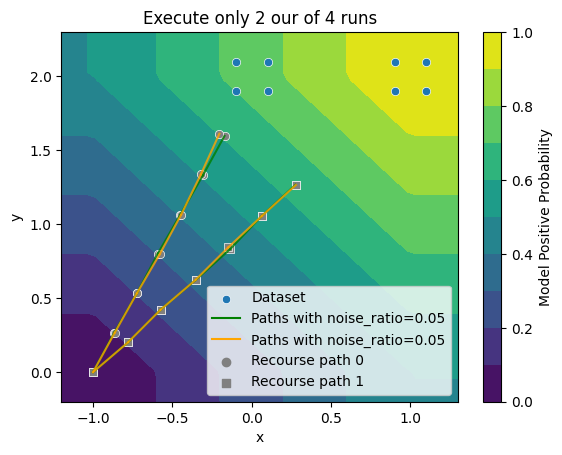

In [49]:
experiment_config = {
    "experiment_name": "test_experiment",
    "num_runs": 2,
    "random_seed": 0,
    "parameter_ranges": {
        "step_size": [0.3],
        "confidence_cutoff": [0.6],
        "noise_ratio": [0.05, 0.8],
        "rescale_ratio": [None],
        "volcano_degree": [2],
        "volcano_cutoff": [0.5],
        "num_clusters": [2],
        "dataset_name": ["toy_data"],
        "model_type": ["toy_model"],
        "max_iterations": [10],
        "cluster_seed": [0]
    }
}

run_mrmc_experiment.main(
    config=experiment_config,
    is_experiment=True,
    verbose=True,
    dry_run=False,
    max_runs=2
)

show_results('../experiment_results/mrmc_results/test_experiment', label_column='noise_ratio')
plt.title("Execute only 2 our of 4 runs")

### Test changing the results directory

Got configs for 4 runs.
Start executing 4 mrmc runs.
Finished run 1/4
Finished run 2/4
Finished run 3/4
Finished run 4/4
Saved results to ../experiments_results/mrmc_results/test_results_dir

Results saved as:
['mrmc_paths_df.csv', 'experiment_config_df.csv', 'config.json', 'cluster_df.csv']


Text(0.5, 1.0, 'Paths as step_size and noise_ratio change')

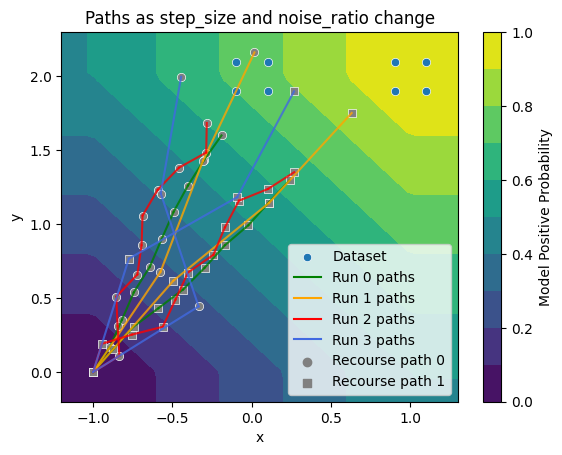

In [50]:
experiment_config = {
    "experiment_name": "test_experiment",
    "num_runs": 1,
    "random_seed": 0,
    "parameter_ranges": {
        "step_size": [0.2, 0.8],
        "confidence_cutoff": [0.6],
        "noise_ratio": [0.1, 0.5],
        "rescale_ratio": [None],
        "volcano_degree": [2],
        "volcano_cutoff": [0.5],
        "num_clusters": [2],
        "dataset_name": ["toy_data"],
        "model_type": ["toy_model"],
        "max_iterations": [10],
        "cluster_seed": [0]
    }
}

results_dir = '../experiments_results/mrmc_results/test_results_dir'

run_mrmc_experiment.main(
    config=experiment_config,
    is_experiment=True,
    verbose=True,
    dry_run=False,
    results_dir=results_dir
)

show_results(results_dir)
plt.title("Paths as step_size and noise_ratio change")